In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from decimal import Decimal
import time
import argparse
from random import shuffle

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

# Prepare Data

In [3]:
parser = {
    'epochs': 3,
    'batch_size': 1,
    'lr': 0.01,
    'cuda': True,
    'seed': 7,
    'results': './results',
    'model_zoo': './model_zoo',
    'best_model': '/best_model_test.pth'
}

args = argparse.Namespace(**parser)
args.cuda = args.cuda and torch.cuda.is_available()
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.model_zoo):
    os.makedirs(args.model_zoo) 
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## Read CSV

In [7]:
songs_1_2000 = pd.read_csv('./static_annotations_averaged_songs_1_2000.csv', sep='\s*,\s*', engine='python')

In [8]:
song_2000s = pd.read_csv('./static_annotations_averaged_songs_2000_2058.csv', sep='\s*,\s*', engine='python')

In [9]:
del songs_1_2000['valence_std']
del songs_1_2000['arousal_std']
for header in list(song_2000s.columns.values):
    if header != 'song_id' and header != 'valence_mean' and header != 'arousal_mean':
        del song_2000s[header]

In [10]:
df = songs_1_2000.append(song_2000s)

In [10]:
# Save our dataframe
#df_out = open("./df_songs", "wb")
#pickle.dump(df, df_out)

# Read data

In [11]:
df_out = open("./dataframe/df_songs", "rb")
df = pickle.load(df_out)

In [12]:
def getValenceArousal(df, songId):
    valence = df.loc[df['song_id'] == songId]['valence_mean'].tolist()[0]
    arousal = df.loc[df['song_id'] == songId]['arousal_mean'].tolist()[0]
    target = (valence/10, arousal/10)
    return list(target)

In [13]:
def getValence(df, songId):
    valence = df.loc[df['song_id'] == songId]['valence_mean'].tolist()[0]
    target = valence/10
    return [target]

In [15]:
listSongs = os.listdir('./my_features/')

In [34]:
songId = df['song_id']

In [35]:
songId = songId.tolist()

In [18]:
def getLongterm(songId):
    f = open("./my_features/"+str(songId), "rb")
    longterm = pickle.load(f, encoding='latin1')
    longterm = list(map(roundUp, longterm))
    return longterm

In [14]:
def getShortTerm(songId):
    f = open("./my_features/"+str(songId), 'rb')
    shortterms = pickle.load(f, encoding='latin1')
    return shortterms

In [15]:
def roundUp(x):
    return round(float(Decimal(x)), 2)

# Get alll short term and scale it

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))

In [23]:
all_shortterms = []
for i in songId:
    all_shortterms += (getShortTerm(i))

In [24]:
scaler.fit(all_shortterms)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [7]:
import pickle

In [866]:
def save_scaler(scaler, fileName):
    f = open('./'+fileName, 'wb')
    pickle.dump(scaler, f, protocol=2)

In [867]:
save_scaler(scaler, "./model_zoo/scalerForShortTerms.sav")

## Load scaler

In [9]:
scaler = pickle.load(open('./model_zoo/scalerForShortTerms.sav', 'rb'))

# Model

In [4]:
class LSTMModel(nn.Module):
    
    def __init__(self, d_input, d_hidden_lstm, num_layer, d_output):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(d_input, d_hidden_lstm, num_layer)
        self.linear1 = nn.Linear(d_hidden_lstm*num_layer, d_hidden_lstm*num_layer)
        self.linear2 = nn.Linear(d_hidden_lstm*num_layer, d_hidden_lstm*num_layer)
        self.linear3 = nn.Linear(d_hidden_lstm*num_layer, d_output)
        self.d_hidden_lstm = d_hidden_lstm
        self.num_layer = num_layer

    def forward(self, x, cuda=False):
        
        tt = torch.cuda if cuda else torch
        h = Variable(tt.FloatTensor(self.num_layer, x.size(1),self.d_hidden_lstm).zero_(), requires_grad=False)
        c = Variable(tt.FloatTensor(self.num_layer, x.size(1), self.d_hidden_lstm).zero_(), requires_grad=False)
        _, (h_t, c_t) = self.lstm1(x, (h, c))
        #h_t = F.tanh(h_t.squeeze(0))
        h_t = F.tanh(h_t)
        out = F.tanh(self.linear1(h_t.view(-1, self.d_hidden_lstm*self.num_layer)))
        out = F.tanh(self.linear2(out))
        out = self.linear3(out)
        return out
    

In [164]:
def train(epoch, model, songId, optimizer, criterion, start_time, config):
    train_loss = 0
    n_total = 0
    listSongId = songId.copy()
    #shuffle(listSongId)
    listSongId_val = listSongId[:int(len(listSongId)* 3/20)]
    listSongId_train = listSongId[int(len(listSongId)* 3/20):]
    shuffle(listSongId_val)
    shuffle(listSongId_train)
    tt = torch.cuda if config.cuda else torch
    for i in listSongId_train:
        model.train()
        target = tt.FloatTensor(getValenceArousal(df=df, songId=i))
        shortterms = tt.FloatTensor(scaler.transform(getShortTerm(i)))
        if config.cuda:
            shorttermsVar = shortterms.cuda()
            target = target.cuda()
        target = Variable(target).view(-1,2)
        shorttermsVar = Variable(shortterms)
        shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
            
        output = model(shorttermsVar, config.cuda)
        
        loss = criterion(output, target)
        train_loss += loss.data[0]*10
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 3)
        optimizer.step()
        n_total += 1

    train_loss /= n_total
    valid_loss, valence_e_rate, arousal_e_rate = validate(model, listSongId_val, criterion, config)
    
    print("=> EPOCH {}|Time: {:3.0f}s | Song Id: {:5} | Train loss: {:.4f} | Val loss: {:.4f}"
          "| Valence: {:.4f} | Arousal: {:.4f}"
                  .format(epoch, time.time()-start_time, i, train_loss, valid_loss, valence_e_rate, arousal_e_rate))
    return valid_loss

In [150]:
def validate(model, listSongId_val, criterion, config):
    model.eval()
    valid_loss = 0
    valence_rate = 0
    arousal_rate = 0
    tt = torch.cuda if config.cuda else torch
    n_total = len(listSongId_val)
    for i in listSongId_val:
        target = tt.FloatTensor(getValenceArousal(df=df, songId=i))
        shortterms = tt.FloatTensor(scaler.transform(getShortTerm(i)))
        if config.cuda:
            shorttermsVar = shortterms.cuda()
            target = target.cuda()
        target = Variable(target).view(-1,2)
        shorttermsVar = Variable(shortterms)
        shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
        
            
        output = model(shorttermsVar, config.cuda)
        loss = criterion(output, target)
        valid_loss += loss.data[0]*10
        valence_error_rate = abs(output.data[0,0]-target.data[0,0])/target.data[0,0]
        arousal_error_rate = abs(output.data[0,1]-target.data[0,1])/target.data[0,1]
        valence_rate += valence_error_rate
        arousal_rate += arousal_error_rate
    valid_loss /= n_total
    valence_rate /= n_total
    arousal_rate /= n_total
    return (valid_loss, valence_rate, arousal_rate)

In [151]:
model = LSTMModel(33, 80, 2, 2)
criterion = nn.MSELoss()

if args.cuda:
    model = model.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

In [152]:
model.parameters

<bound method Module.parameters of LSTMModel (
  (lstm1): LSTM(33, 80, num_layers=2)
  (linear1): Linear (160 -> 160)
  (linear2): Linear (160 -> 160)
  (linear3): Linear (160 -> 2)
)>

In [156]:
optimizer = optim.Adagrad(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [174]:
best_valid_loss = 10
for epoch in range(0, 300):
    start_time = time.time()
    #train_test(epoch, model, listSongId=songId, optimizer=optimizer, criterion=criterion)
    valid_loss = train(epoch, model, songId=songId, optimizer=optimizer, criterion=criterion, start_time=start_time, config=args)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), args.model_zoo + args.best_model)

=> EPOCH 0|Time:  13s | Song Id:  1432 | Train loss: 0.0687 | Val loss: 0.1010| Valence: 0.1853 | Arousal: 0.2078
=> EPOCH 1|Time:  13s | Song Id:   502 | Train loss: 0.0687 | Val loss: 0.1013| Valence: 0.1857 | Arousal: 0.2081
=> EPOCH 2|Time:  13s | Song Id:  1308 | Train loss: 0.0686 | Val loss: 0.1016| Valence: 0.1861 | Arousal: 0.2084
=> EPOCH 3|Time:  13s | Song Id:   402 | Train loss: 0.0686 | Val loss: 0.1018| Valence: 0.1865 | Arousal: 0.2086
=> EPOCH 4|Time:  13s | Song Id:   320 | Train loss: 0.0686 | Val loss: 0.1021| Valence: 0.1867 | Arousal: 0.2089
=> EPOCH 5|Time:  13s | Song Id:   597 | Train loss: 0.0685 | Val loss: 0.1023| Valence: 0.1870 | Arousal: 0.2091
=> EPOCH 6|Time:  13s | Song Id:  1635 | Train loss: 0.0685 | Val loss: 0.1025| Valence: 0.1873 | Arousal: 0.2093
=> EPOCH 7|Time:  13s | Song Id:   921 | Train loss: 0.0685 | Val loss: 0.1027| Valence: 0.1876 | Arousal: 0.2095
=> EPOCH 8|Time:  13s | Song Id:  1942 | Train loss: 0.0685 | Val loss: 0.1029| Valence:

=> EPOCH 72|Time:  13s | Song Id:  1337 | Train loss: 0.0681 | Val loss: 0.1087| Valence: 0.1940 | Arousal: 0.2152
=> EPOCH 73|Time:  13s | Song Id:  1825 | Train loss: 0.0681 | Val loss: 0.1088| Valence: 0.1940 | Arousal: 0.2152
=> EPOCH 74|Time:  13s | Song Id:  1939 | Train loss: 0.0681 | Val loss: 0.1088| Valence: 0.1940 | Arousal: 0.2153
=> EPOCH 75|Time:  13s | Song Id:   611 | Train loss: 0.0681 | Val loss: 0.1089| Valence: 0.1942 | Arousal: 0.2153
=> EPOCH 76|Time:  13s | Song Id:  1642 | Train loss: 0.0681 | Val loss: 0.1089| Valence: 0.1942 | Arousal: 0.2154
=> EPOCH 77|Time:  13s | Song Id:  1635 | Train loss: 0.0681 | Val loss: 0.1089| Valence: 0.1942 | Arousal: 0.2154
=> EPOCH 78|Time:  13s | Song Id:  1474 | Train loss: 0.0681 | Val loss: 0.1090| Valence: 0.1943 | Arousal: 0.2154
=> EPOCH 79|Time:  13s | Song Id:  1659 | Train loss: 0.0681 | Val loss: 0.1090| Valence: 0.1943 | Arousal: 0.2155
=> EPOCH 80|Time:  13s | Song Id:  1786 | Train loss: 0.0681 | Val loss: 0.1090|

=> EPOCH 143|Time:  13s | Song Id:   544 | Train loss: 0.0680 | Val loss: 0.1107| Valence: 0.1958 | Arousal: 0.2172
=> EPOCH 144|Time:  13s | Song Id:  1407 | Train loss: 0.0680 | Val loss: 0.1107| Valence: 0.1957 | Arousal: 0.2172
=> EPOCH 145|Time:  13s | Song Id:   769 | Train loss: 0.0680 | Val loss: 0.1107| Valence: 0.1958 | Arousal: 0.2173
=> EPOCH 146|Time:  13s | Song Id:  1591 | Train loss: 0.0680 | Val loss: 0.1108| Valence: 0.1958 | Arousal: 0.2173
=> EPOCH 147|Time:  13s | Song Id:  1489 | Train loss: 0.0680 | Val loss: 0.1108| Valence: 0.1958 | Arousal: 0.2173
=> EPOCH 148|Time:  13s | Song Id:  1311 | Train loss: 0.0680 | Val loss: 0.1108| Valence: 0.1958 | Arousal: 0.2173
=> EPOCH 149|Time:  13s | Song Id:   649 | Train loss: 0.0680 | Val loss: 0.1108| Valence: 0.1958 | Arousal: 0.2173
=> EPOCH 150|Time:  13s | Song Id:  1842 | Train loss: 0.0680 | Val loss: 0.1108| Valence: 0.1958 | Arousal: 0.2174
=> EPOCH 151|Time:  13s | Song Id:  1342 | Train loss: 0.0680 | Val loss

=> EPOCH 214|Time:  13s | Song Id:   644 | Train loss: 0.0679 | Val loss: 0.1119| Valence: 0.1967 | Arousal: 0.2185
=> EPOCH 215|Time:  13s | Song Id:  1531 | Train loss: 0.0679 | Val loss: 0.1120| Valence: 0.1967 | Arousal: 0.2185
=> EPOCH 216|Time:  13s | Song Id:  1444 | Train loss: 0.0679 | Val loss: 0.1120| Valence: 0.1967 | Arousal: 0.2185
=> EPOCH 217|Time:  13s | Song Id:  1384 | Train loss: 0.0679 | Val loss: 0.1120| Valence: 0.1967 | Arousal: 0.2185
=> EPOCH 218|Time:  13s | Song Id:  1800 | Train loss: 0.0679 | Val loss: 0.1120| Valence: 0.1967 | Arousal: 0.2186
=> EPOCH 219|Time:  13s | Song Id:   501 | Train loss: 0.0679 | Val loss: 0.1120| Valence: 0.1967 | Arousal: 0.2186
=> EPOCH 220|Time:  13s | Song Id:   830 | Train loss: 0.0679 | Val loss: 0.1121| Valence: 0.1968 | Arousal: 0.2186
=> EPOCH 221|Time:  13s | Song Id:  1868 | Train loss: 0.0679 | Val loss: 0.1121| Valence: 0.1968 | Arousal: 0.2186
=> EPOCH 222|Time:  13s | Song Id:  1221 | Train loss: 0.0679 | Val loss

=> EPOCH 285|Time:  13s | Song Id:  1067 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1974 | Arousal: 0.2195
=> EPOCH 286|Time:  13s | Song Id:  1514 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1974 | Arousal: 0.2195
=> EPOCH 287|Time:  13s | Song Id:  1283 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1974 | Arousal: 0.2195
=> EPOCH 288|Time:  13s | Song Id:  1237 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1974 | Arousal: 0.2196
=> EPOCH 289|Time:  13s | Song Id:  1111 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1974 | Arousal: 0.2196
=> EPOCH 290|Time:  13s | Song Id:  1929 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1974 | Arousal: 0.2196
=> EPOCH 291|Time:  13s | Song Id:   460 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1975 | Arousal: 0.2196
=> EPOCH 292|Time:  13s | Song Id:   702 | Train loss: 0.0679 | Val loss: 0.1130| Valence: 0.1975 | Arousal: 0.2196
=> EPOCH 293|Time:  13s | Song Id:  1850 | Train loss: 0.0679 | Val loss

In [158]:
train_losses = [0.1326, 0.1052, 0.1029, 0.1011, 0.0995, 0.0981, 0.0968, 
 0.0956, 0.0945, 0.0934, 0.0924, 0.0914, 0.0905, 0.0896, 
 0.0888, 0.0881, 0.0873, 0.0867, 0.0860, 0.0854, 0.0849,
 0.0844, 0.0839, 0.0835, 0.0831, 0.0828, 0.0825, 0.0822,
 0.0819, 0.0817]
val_losses = [0.1504, 0.1467, 0.1442, 0.1424, 0.1410, 0.1399, 0.1390,
              0.1382, 0.1377, 0.1372, 0.1368, 0.1365, 0.1363, 0.1362,
              0.1361, 0.1361, 0.1362, 0.1363, 0.1364, 0.1366, 0.1368,
              0.1371, 0.1373, 0.1376, 0.1379, 0.1382, 0.1385, 0.1388, 
              0.1391, 0.1394]

In [178]:
best_valid_loss

0.10102746063111462

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 20
rcParams['xtick.labelsize'] = 22
rcParams['ytick.labelsize'] = 22

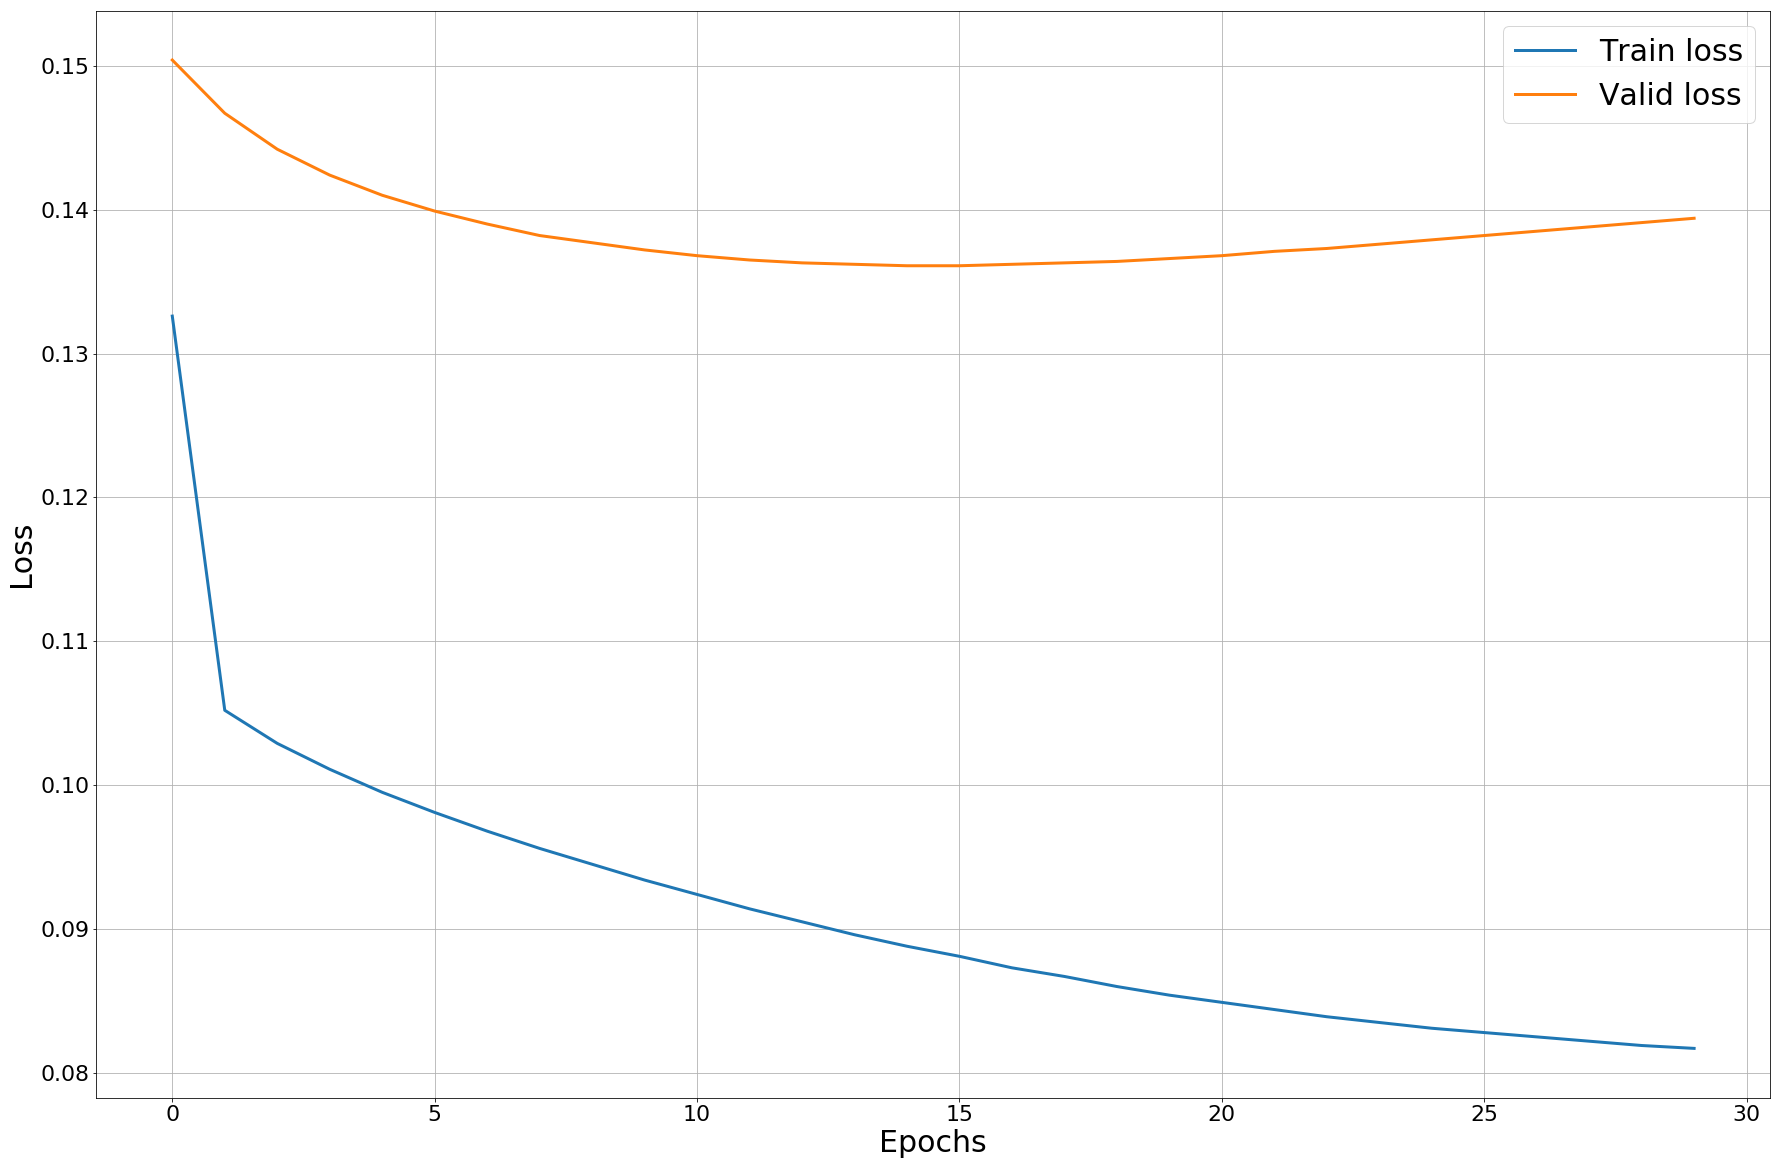

In [161]:
plt.plot(train_losses, linewidth=3, label="Train loss")
plt.plot(val_losses, linewidth=3, label="Valid loss")
plt.grid()
plt.legend(fontsize=30)
plt.xlabel("Epochs", fontsize=30)
plt.ylabel("Loss", fontsize=30)
plt.show()

In [171]:
tt = torch.cuda if args.cuda else torch
target = tt.FloatTensor(getValenceArousal(df=df, songId=12))
shortterms = tt.FloatTensor(scaler.transform(getShortTerm(12)))
if args.cuda:
    shorttermsVar = shortterms.cuda()
    target = target.cuda()
target = Variable(target).view(-1,2)
shorttermsVar = Variable(shortterms)
shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)

In [175]:
out1= model(shorttermsVar, args.cuda)

In [176]:
out1.data[0,1]*10

5.4681771993637085

In [177]:
out1.t()

Variable containing:
 0.5883
 0.5468
[torch.cuda.FloatTensor of size 2x1 (GPU 0)]

In [801]:
list(model.lstm1.parameters())[:2]

[Parameter containing:
  4.4036e-02  1.7066e-01  3.9493e-02  ...   8.9807e-02  1.9173e-02  8.5699e-02
  3.4440e-02  3.3277e-02  1.2085e-01  ...  -7.9660e-02  8.3330e-02 -1.1702e-01
 -1.0108e-01  3.3738e-02 -4.2567e-02  ...  -1.9556e-01 -1.5576e-01 -1.9866e-01
                 ...                   ⋱                   ...                
 -7.5637e-02 -1.4580e-02  3.3025e-02  ...   7.5864e-02  1.8499e-01 -3.9865e-02
  1.1696e-01  4.5942e-02  1.0562e-01  ...   1.6747e-01 -9.2520e-02  1.5085e-01
  1.1638e-01 -1.1257e-01  1.5411e-01  ...   7.2195e-02 -1.6673e-01  4.4452e-03
 [torch.FloatTensor of size 120x33], Parameter containing:
 -1.3485e-01 -1.4152e-01 -1.5621e-01  ...   1.6920e-01 -9.7852e-02 -1.0219e-01
 -1.0319e-01  8.9539e-02  1.3251e-01  ...  -2.0327e-01 -1.0612e-01  1.4252e-01
  7.7742e-02  1.2853e-01  1.1811e-02  ...   1.6655e-01  3.9671e-02  1.0364e-01
                 ...                   ⋱                   ...                
 -1.9411e-01 -7.3102e-02  1.1108e-01  ...  -2.033

In [899]:
torch.save(model.state_dict(), args.model_zoo + args.best_model)

In [888]:
target = getValenceArousal(df=df, songId=2)

In [873]:
target

Variable containing:
 0.5500  0.5800
[torch.FloatTensor of size 1x2]

In [675]:
loss = criterion(out1, target)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [676]:
print(loss)

Variable containing:
nan
[torch.FloatTensor of size 1]



In [637]:
model(shorttermsVar)

Variable containing:
1.00000e-02 *
 -0.2639 -1.3220
[torch.FloatTensor of size 1x2]

In [638]:
target

Variable containing:
 0.3400  0.2800
[torch.FloatTensor of size 1x2]

In [639]:
target.data[0,1]

0.2800000011920929

# LOAD model

In [5]:
model_load = LSTMModel(33, 80, 2, 2)    
model_load.load_state_dict(torch.load("./model_zoo/best_model_test.pth", map_location=lambda storage, loc: storage))


In [183]:
aDict = {"valence_mean_predicted": [], "arousal_mean_predicted": []}
for i in songId:
    shortterms = scaler.transform(getShortTerm(i))
    shorttermsVar = Variable(torch.FloatTensor(shortterms))
    shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
    output = model_load(shorttermsVar)
    valence, arousal = output.data[0,0]*10, output.data[0,1]*10
    aDict["valence_mean_predicted"].append(valence)
    aDict["arousal_mean_predicted"].append(arousal)

In [184]:
aDict["songId"]= songId

In [185]:
df_predicted = pd.DataFrame.from_dict(aDict)

In [186]:
df_predicted.head(20)

,arousal_mean_predicted,songId,valence_mean_predicted
0,5.225573,2,4.947950
1,3.442300,3,3.580140
2,5.395491,4,5.387963
3,4.974052,5,5.292026
4,5.060851,7,5.031670
5,3.867198,8,4.256176
6,4.731344,10,4.746169
7,5.360028,12,5.791211
8,4.146194,13,4.520081
9,5.165197,17,5.596814


In [905]:
col = df_predicted.columns.tolist()

In [906]:
col = ['songId', 'valence_mean_predicted', 'arousal_mean_predicted']

In [907]:
df_predicted = df_predicted[col]

In [908]:
df_predicted.to_csv("./dfVALSTMPredictionBestTrainLoss.csv")

In [911]:
getValenceArousal(df,35)

Variable containing:
 0.4800  0.6500
[torch.FloatTensor of size 1x2]

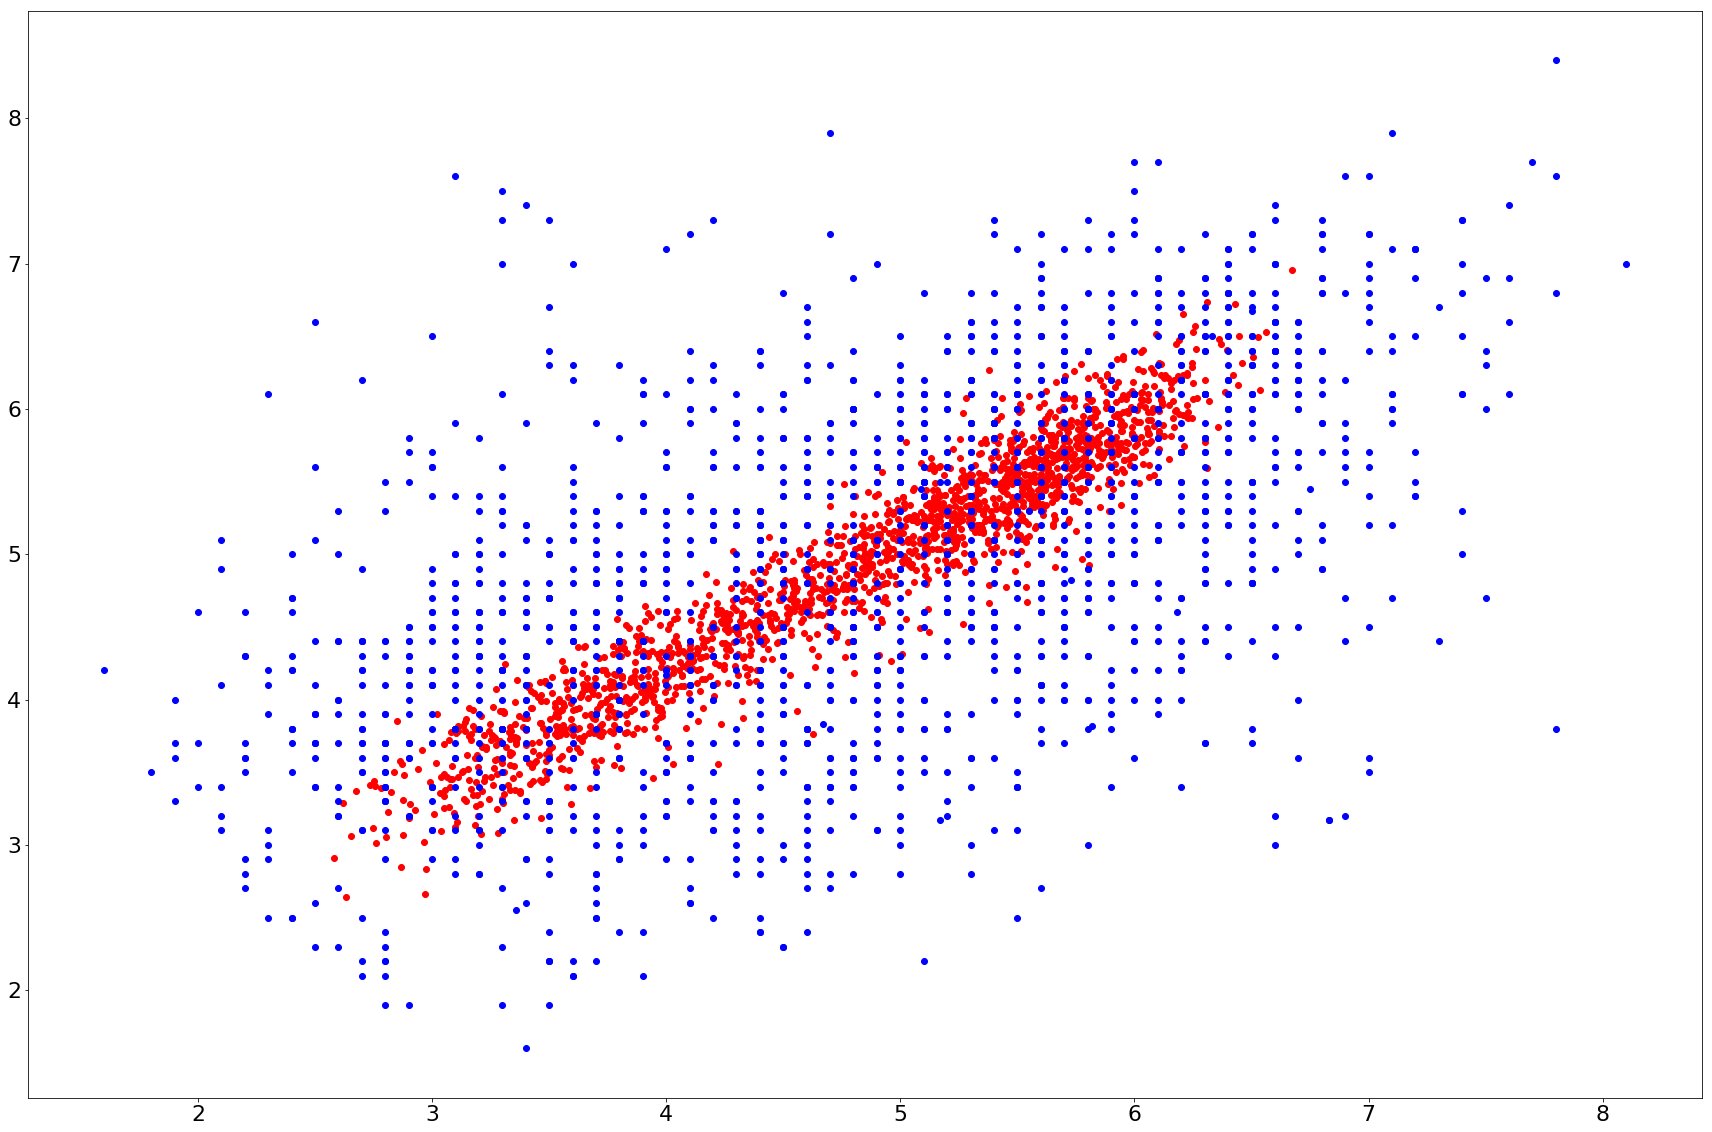

In [193]:
plt.plot(aDict['arousal_mean_predicted'], aDict['valence_mean_predicted'], 'ro')
plt.plot(df['arousal_mean'].tolist(), df['valence_mean'], 'bo')
plt.show()

# Get hidden output from LSTM layer

In [41]:
aList = []
for i in songId:
    shortterms = scaler.transform(getShortTerm(i))
    shorttermsVar = Variable(torch.FloatTensor(shortterms))
    shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
    _, (h, c)= model_load.lstm1(shorttermsVar)
    aList.append(h.data.view(-1).numpy())

In [42]:
dfHiddenFeatures = pd.DataFrame(aList)

In [43]:
dfHiddenFeatures.to_csv('./dataframe/dfHiddenFeatures.csv')

In [44]:
dfHiddenFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,0.000593,0.060167,0.028834,-0.005534,-0.012039,-0.015634,0.056722,0.006053,-0.011204,0.014445,...,-0.004244,-0.046868,0.004451,-0.020912,-0.014719,0.001081,0.000878,-0.006346,-0.010257,0.031382
1,0.016794,0.029682,-0.038735,0.066277,0.033157,-0.116560,-0.022503,-0.023076,-0.073993,-0.029360,...,-0.031769,-0.034314,0.004654,-0.003986,0.011159,0.009411,-0.004962,-0.022303,0.003772,0.009494
2,0.024344,-0.003684,0.061999,0.004546,-0.033585,0.088068,0.052630,0.011006,-0.025468,0.020444,...,-0.009197,-0.046493,-0.002118,-0.004183,0.002550,0.000299,0.001702,-0.006680,-0.008872,0.007989
3,-0.026184,0.019066,0.018694,0.006746,0.004495,0.041304,-0.010962,-0.017689,0.023157,0.030066,...,-0.011042,-0.042471,-0.015822,0.013292,0.006990,0.002237,-0.006627,-0.025501,-0.012994,0.005698
4,-0.058277,0.019705,-0.003511,-0.057026,0.014113,0.051973,0.003513,-0.011199,-0.023297,0.032917,...,-0.005447,-0.039411,0.001856,-0.018505,-0.001068,-0.005463,0.004466,-0.013750,0.004538,0.026163
